# **PRACTICA DEEP LEARNING**

### Problema: *Estimar el precio de las habitaciones de Airbnb*
#### Requerimiento: Utilizar DL (Redes Neuronales Profundas)

### Desarrollo:
#### Módulo 1: Estimar los precios mediante un modelo basado en imágenes y un modelo basado en datos 1D
#### Módulo 2: Desarrollar un modelo que combine datos 1-D e imágenes para calcular los precios de las habitaciones (modelos hibridos)

## 1. Preparación de los Datos y Dataframes

### 1.1 Carga de Librerías

In [ ]:
# Librerías

from google.colab import drive
import zipfile
import os
import cv2
import glob
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import random
import shutil
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp, Trials
from tensorflow.keras import callbacks, optimizers, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

### 1.2 Visualización inicial del Dataset

In [ ]:
# Carga de Dataset --> [Imágenes]
# Descomprimir (archivo .zip)
# Extracción y ubicación de imágenes descomprimidas en carpeta especificada

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ruta_archivo_zip = '/content/drive/MyDrive/Bootcamp AI&ML KC/DL/airbnb_images.zip'
ruta_extraccion = '/content/drive/MyDrive/Bootcamp AI&ML KC/DL/imagenes'

with zipfile.ZipFile(ruta_archivo_zip, 'r') as zip_ref:
    zip_ref.extractall(ruta_extraccion)

In [ ]:
# Validar cantidad de imágenes en la carpeta
ruta_extraccion = '/content/drive/MyDrive/Bootcamp AI&ML KC/DL/imagenes/airbnb_images'
file_list = os.listdir(ruta_extraccion)
image_files = [file for file in file_list if file.endswith(('.jpg', '.jpeg', '.png'))]
n_images = len(image_files)
print('Cantidad de imágenes en la carpeta:', n_images)

Cantidad de imágenes en la carpeta: 14751


In [ ]:
# Carga de Dataset --> [Datos 1D]
# Carga (archivo .csv)
# Definir Dataframe=df_airbnb_listings
# Visualizar contenido del Dataframe (Filas=5, Columnas=All)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ruta_csv = '/content/drive/MyDrive/Bootcamp AI&ML KC/DL/airbnb-listings.csv'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_airbnb_listings = pd.read_csv(ruta_csv, sep=';')
df_airbnb_listings.head(5).T

,0,1,2,3,4
ID,13531067,15459188,13184463,17115175,6766647
Listing Url,https://www.airbnb.com/rooms/13531067,https://www.airbnb.com/rooms/15459188,https://www.airbnb.com/rooms/13184463,https://www.airbnb.com/rooms/17115175,https://www.airbnb.com/rooms/6766647
Scrape ID,20170402075052,20170407214050,20170407214050,20170407214050,20170306202425
Last Scraped,2017-04-02,2017-04-08,2017-04-08,2017-04-08,2017-03-07
Name,"AMSTERDAM, OUD-WEST",Paseo De Gracia I (433),"Rooftop 2 terraces full of art, style and views",Flat close to Plaza España - Eixample,"5 Minutes to Downtown, Zilker!"
Summary,Cozy private room with a double bed in Oud-Wes...,"Unique apartment in vibrant neighborhoods, car...","Our place is In the cross between Born, Barce...","- Comfortable and clean double bedroom, with a...","Get everywhere in minutes! Charming, tradition..."
Space,NaN,"Its high ceilings, wooden floors, large window...",The views above Barcelona are unique. The styl...,NaN,Located on a large tree-covered lot less than ...
Description,Cozy private room with a double bed in Oud-Wes...,"Unique apartment in vibrant neighborhoods, car...","Our place is In the cross between Born, Barce...","- Comfortable and clean double bedroom, with a...","Get everywhere in minutes! Charming, tradition..."
Experiences Offered,none,none,none,none,none
Neighborhood Overview,NaN,NaN,NaN,NaN,The Tarrytown neighborhood is best known for i...


In [ ]:
# Visualizar número de filas (Rows) del df=Datos en Bruto)
num_filas = df_airbnb_listings.shape[0]
print('Número de filas en el DataFrame:', num_filas)

Número de filas en el DataFrame: 14780


### 1.3 Eliminar Filas (No se descargaron las imágenes)

In [ ]:
# Obtener (Lista de archivos en carpeta airbnb_images)
# Extraer (Num de las imágenes del nombre del archivo. pj: 0_100.0)
# Crear (Columna aux. en df_airbnb_listings para comparar con num de las imágenes)
# Filtrar (df para mantener filas de imágenes descargadas)
# Eliminar (La columna auxiliar)
ruta_carp_imag = '/content/drive/MyDrive/Bootcamp AI&ML KC/DL/imagenes/airbnb_images'
list_arch = os.listdir(ruta_carp_imag)
num_imag_desc = []

for archivo in list_arch:
    try:
        num = int(os.path.splitext(archivo)[0].split('_')[0])
        num_imag_desc.append(num)
    except ValueError:
        continue

df_airbnb_listings['imagen_descargada'] = df_airbnb_listings.index.isin(num_imag_desc)
df_airbnb_listings = df_airbnb_listings[df_airbnb_listings['imagen_descargada']]

In [ ]:
# Visualizar número de filas (Rows) del Nuevo df con Filas Eliminadas(No se descargaron las imágenes)
num_filas = df_airbnb_listings.shape[0]
print('Número de filas en el DataFrame:', num_filas)

Número de filas en el DataFrame: 14751


In [ ]:
# Num filas de Df=Num.Imágenes
print(num_filas)
print(n_images)

14751
14751


### 1.4 Seleccionar las Columnas de Interés

In [ ]:
# Columnas de Interés (Variables) en df
colum_inter = ['Property Type', 'Room Type', 'Cancellation Policy', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds',
                     'Guests Included', 'Extra People', 'Minimum Nights', 'Maximum Nights', 'Number of Reviews',
                     'Host Total Listings Count', 'Price']
df_airbnb_listings = df_airbnb_listings.loc[:, colum_inter]
df_airbnb_listings.head()

,Property Type,Room Type,Cancellation Policy,Accommodates,Bathrooms,Bedrooms,Beds,Guests Included,Extra People,Minimum Nights,Maximum Nights,Number of Reviews,Host Total Listings Count,Price
0,Apartment,Private room,moderate,2,1.0,1.0,1.0,1,0,2,1125,6,1.0,100.0
1,Apartment,Entire home/apt,strict,4,1.0,2.0,3.0,1,0,2,1125,1,207.0,94.0
2,Apartment,Entire home/apt,flexible,3,1.5,1.0,1.0,2,20,1,30,9,1.0,115.0
3,Apartment,Private room,strict,1,1.0,1.0,1.0,1,0,3,5,1,1.0,200.0
4,House,Entire home/apt,strict,6,2.0,3.0,3.0,1,0,3,1125,1,1.0,795.0


## 2. Análisis Exploratorio de los Datos

### 2.1 Carpeta [Imágenes]

In [ ]:
# Validar Forma (shape) de las imágenes
# Recorrer las imágenes y obtener sus formas
# Mostrar número de tipos de formas únicas encontradas

ruta_carpeta_imagenes = '/content/drive/MyDrive/Bootcamp AI&ML KC/DL/imagenes/airbnb_images/*.jpg'
rutas_imagenes = glob.glob(ruta_carpeta_imagenes)
formas_val = []

for ruta_imagen in rutas_imagenes:
    imagen = cv2.imread(ruta_imagen)

    if imagen is not None:
        forma = imagen.shape
        formas_val.append(forma)
    else:
        print(f"No se pudo cargar la imagen: {ruta_imagen}")

formas_unicas = set(formas_val)
num_formas_unicas = len(formas_unicas)
print(f"Número de tipos de formas (shapes) únicas: {num_formas_unicas}")

Número de tipos de formas (shapes) únicas: 505


### 2.2 Dataframe [Datos 1D]

In [ ]:
# Información Estadística del df
data_describe = df_airbnb_listings.describe()
data_describe

,Accommodates,Bathrooms,Bedrooms,Beds,Guests Included,Extra People,Minimum Nights,Maximum Nights,Number of Reviews,Host Total Listings Count,Price
count,14751.000000,14699.000000,14726.000000,14702.000000,14751.000000,14751.000000,14751.000000,14751.000000,14751.000000,14748.000000,14734.000000
mean,3.278422,1.282026,1.343746,2.045096,1.590536,7.696563,3.051522,945.415497,22.628296,12.532411,73.586535
std,2.097869,0.658977,0.900404,1.613727,1.183412,12.980841,12.278383,8447.585486,38.293071,34.120785,72.097290
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,9.000000
25%,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,365.000000,1.000000,1.000000,34.000000
50%,3.000000,1.000000,1.000000,2.000000,1.000000,0.000000,2.000000,1125.000000,7.000000,2.000000,55.000000
75%,4.000000,1.000000,2.000000,2.000000,2.000000,15.000000,3.000000,1125.000000,27.000000,6.000000,86.000000
max,16.000000,8.000000,10.000000,16.000000,16.000000,500.000000,1125.000000,1000000.000000,446.000000,519.000000,999.000000


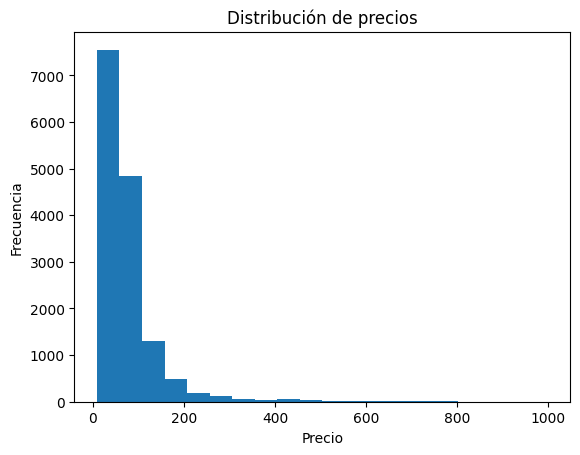

In [ ]:
# Validar la distribución de la variable objetivo --> (Price)
plt.hist(df_airbnb_listings['Price'], bins=20)
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Distribución de precios')
plt.show()

In [ ]:
# Tipos de Datos del df
data_types = df_airbnb_listings.dtypes
data_types

Property Type                 object
Room Type                     object
Cancellation Policy           object
Accommodates                   int64
Bathrooms                    float64
Bedrooms                     float64
Beds                         float64
Guests Included                int64
Extra People                   int64
Minimum Nights                 int64
Maximum Nights                 int64
Number of Reviews              int64
Host Total Listings Count    float64
Price                        float64
dtype: object

In [ ]:
# Identificar (Valores Nulls dentro del df)
# Ordenar (Valores Nulls->Descendente)
# Variables (Mayor número de valores Nulls)
nulls_val = df_airbnb_listings.isnull().sum()
nulls_val_sorted = nulls_val.sort_values(ascending=False)
variables_con_nulls = nulls_val_sorted[nulls_val_sorted > 0]
print(variables_con_nulls)

Bathrooms                    52
Beds                         49
Bedrooms                     25
Price                        17
Host Total Listings Count     3
dtype: int64


True
Property Type                 0
Room Type                     0
Cancellation Policy           0
Accommodates                  0
Bathrooms                    52
Bedrooms                     25
Beds                         49
Guests Included               0
Extra People                  0
Minimum Nights                0
Maximum Nights                0
Number of Reviews             0
Host Total Listings Count     3
Price                        17
dtype: int64


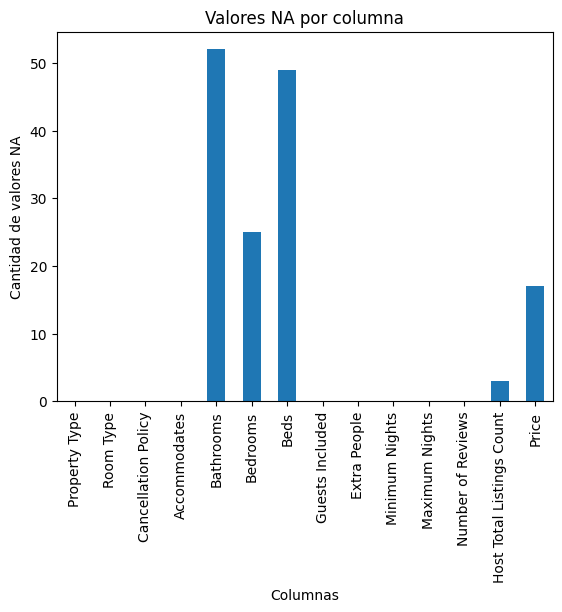

In [ ]:
# Verificar (Valores NA en el df) *Nota: NA=Null
# Identificar (Valores NA por columna)
# Visualizar (Valores NA)
print(df_airbnb_listings.isna().any().any())
na_counts = df_airbnb_listings.isna().sum()
print(na_counts)
na_counts.plot(kind='bar')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de valores NA')
plt.title('Valores NA por columna')
plt.show()

## 3. Limpieza y Pre-Procesamiento de los Datos

### 3.1 Pre-Procesamiento [Imágenes]

#### 3.1.1 Dividir archivos en Carpeta en (Train, Val y Test)

In [ ]:
# Acceder a las imágenes en Carpeta
# Definir (Ruta=Path almacenamiento de subsets --> train, val y test)
# Definir % de asignación (train, val y test)
# Definir shuffle (Nombres de archivo de manera aleatoria)
# Calcular (Longitudes de cada subset)
# Dividir (Lista de nombres de archivo en conjuntos de train, val y test)
# Asignar (Imágenes a carpetas de cada subset)
ruta_imagenes = '/content/drive/MyDrive/Bootcamp AI&ML KC/DL/imagenes/airbnb_images'
ruta_train = '/content/drive/MyDrive/Bootcamp AI&ML KC/DL/imagenes/train'
ruta_val = '/content/drive/MyDrive/Bootcamp AI&ML KC/DL/imagenes/val'
ruta_test = '/content/drive/MyDrive/Bootcamp AI&ML KC/DL/imagenes/test'

perc_train = 0.8
perc_val = 0.15
perc_test = 0.2

lista_archivos = os.listdir(ruta_imagenes)
random.shuffle(lista_archivos)

total_archivos = len(lista_archivos)
num_train = int(total_archivos * perc_train)
num_val = int(total_archivos * perc_val)
num_test = total_archivos - num_train - num_val

lista_train = lista_archivos[:num_train]
lista_val = lista_archivos[num_train:num_train + num_val]
lista_test = lista_archivos[num_train + num_val:]

for archivo in lista_train:
    origen = os.path.join(ruta_imagenes, archivo)
    destino = os.path.join(ruta_train, archivo)
    shutil.move(origen, destino)

for archivo in lista_val:
    origen = os.path.join(ruta_imagenes, archivo)
    destino = os.path.join(ruta_val, archivo)
    shutil.move(origen, destino)

for archivo in lista_test:
    origen = os.path.join(ruta_imagenes, archivo)
    destino = os.path.join(ruta_test, archivo)
    shutil.move(origen, destino)

print("Train: ", len(os.listdir(ruta_train)))
print("Validation: ", len(os.listdir(ruta_val)))
print("Test: ", len(os.listdir(ruta_test)))

Train:  14753
Validation:  11898
Test:  5943


In [ ]:
# Crear X_train, X_val, X_test
# Función para cargar y redimensionar una imagen
# Definir (Tamaño objetivo para redimensionar las imágenes)
# Cargar y redimensionar (Imágenes de X_train, X_val, X_test)
def cargar_imagen(ruta_imagen, target_size):
    imagen = Image.open(ruta_imagen)
    imagen_redimensionada = imagen.resize(target_size)
    return imagen_redimensionada

target_size = (96, 96)

X_train = [cargar_imagen(os.path.join(ruta_train, file_name), target_size) for file_name in os.listdir(ruta_train) if file_name.endswith('.jpg')]
X_train = np.array(X_train)

X_val = [cargar_imagen(os.path.join(ruta_val, file_name), target_size) for file_name in os.listdir(ruta_val) if file_name.endswith('.jpg')]
X_val = np.array(X_val)

X_test = [cargar_imagen(os.path.join(ruta_test, file_name), target_size) for file_name in os.listdir(ruta_test) if file_name.endswith('.jpg')]
X_test = np.array(X_test)


<ipython-input-20-8d019ccdb7ff>:13: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X_train = np.array(X_train)
<ipython-input-20-8d019ccdb7ff>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array(X_train)
<ipython-input-20-8d019ccdb7ff>:16: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (

In [ ]:
def cargar_imagen(ruta_imagen, target_size):
    imagen = cv2.imread(ruta_imagen)
    imagen_redimensionada = cv2.resize(imagen, target_size)
    return imagen_redimensionada

target_size = (96, 96)  # Tamaño objetivo para las imágenes
X_train = [cargar_imagen(os.path.join(ruta_train, file_name), target_size) for file_name in os.listdir(ruta_train) if file_name.endswith('.jpg')]
X_train = [np.array(img) for img in X_train]  # Convertir las imágenes en arreglos numéricos
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)




In [ ]:
# Crear las listas de etiquetas utilizando compresión de listas
# # Etiquetar (Imágenes)
# Crear (Diccionario-->etiquetas)
# Iterar (En archivos de train)
# Extraer (índice y Precio del nombre del archivo)
# Asociar (Imagen con Etiqueta del Precio)
# Asignar y_train, y_val, y_test
etiquetas = {}

for file_name in os.listdir(ruta_train):
    if file_name.endswith('.jpg'):
        indice_hab = file_name.split('_')[0]
        precio_hab = float(file_name.split('_')[1].split('.')[0])

        etiquetas[file_name] = precio_hab

y_train = [etiquetas[file_name] for file_name in os.listdir(ruta_train) if file_name.endswith('.jpg')]
y_val = [etiquetas[file_name] for file_name in os.listdir(ruta_val) if file_name.endswith('.jpg')]
y_test = [etiquetas[file_name] for file_name in os.listdir(ruta_test) if file_name.endswith('.jpg')]

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
# Convertir y_train en un tensor
# Convertir X_val en un tensor
# Convertir y_val en un tensor
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

X_val = [cargar_imagen(os.path.join(ruta_val, file_name), target_size) for file_name in os.listdir(ruta_val) if file_name.endswith('.jpg')]
X_val = [np.array(img) for img in X_val]  # Convertir las imágenes en arreglos numéricos
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)

y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)

### 3.1.2 Normalizar y Redimensionar las Imágenes

In [ ]:
# Normalizar (Imágenes)
# Construir (Ruta completa de cada imagen)
# Leer (Imagen en color)
# Normalizar (c/canal de color)
# Convertir (Imagen a float32)
# Guardar (Imagen normalizada)
def normalize_images(folder_path):
    for file_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, file_name)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        if image is not None:
            normalized_image = image.astype(np.float32) / 255.0
            cv2.imwrite(image_path, normalized_image)

folder_path = '/content/drive/MyDrive/Bootcamp AI&ML KC/DL/imagenes/train'
normalize_images(folder_path)

In [ ]:
# Redimensionar (Imágenes)
# Definir (Tamaño objetivo-->redimensionar las imágenes)
# Redimensionar (Imágenes en subset train)
def resize_images(folder_path, target_size):
    for file_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, file_name)
        image = cv2.imread(image_path)

        if image is not None:
            resized_image = cv2.resize(image, target_size)
            cv2.imwrite(image_path, resized_image)

folder_path = '/content/drive/MyDrive/Bootcamp AI&ML KC/DL/imagenes/train'
target_size = (64, 64)
resize_images(folder_path, target_size)
num_images = len(os.listdir(folder_path))
print("Train:", num_images)

Train: 14753


In [ ]:
# Etiquetas (Primeras 5 filas)
head_etiquet = dict(list(etiquetas.items())[:5])
for file_name, precio_habitacion in head_etiquet.items():
    print(f"'{file_name}': {precio_habitacion}")

'4281_35.0.jpg': 35.0
'4247_40.0.jpg': 40.0
'4400_70.0.jpg': 70.0
'4242_79.0.jpg': 79.0
'4226_100.0.jpg': 100.0


### 3.2 Pre-Procesamiento de Dataframe [Datos 1D]

#### 3.2.1 Imputación de NA, Null y NaN (Missing Values) del Dataframe

In [ ]:
# Imputar (Valores NA, Null y NaN) (Dato a utilizar --> Mediana=median debido a que puede ser más robusta)
# Verificar (Si hay valores NA, Null y NaN)
df_airbnb_listings = df_airbnb_listings.fillna(df_airbnb_listings.median().iloc[0])
print(df_airbnb_listings.isna().any().any())

False


<ipython-input-25-778cb11d4f4e>:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_airbnb_listings = df_airbnb_listings.fillna(df_airbnb_listings.median().iloc[0])


In [ ]:
na_counts_notNA = df_airbnb_listings.isna().sum()
print(na_counts_notNA)

Property Type                0
Room Type                    0
Cancellation Policy          0
Accommodates                 0
Bathrooms                    0
Bedrooms                     0
Beds                         0
Guests Included              0
Extra People                 0
Minimum Nights               0
Maximum Nights               0
Number of Reviews            0
Host Total Listings Count    0
Price                        0
dtype: int64


#### 3.2.2 Dividir el Dataset en (Train, Val y Test)

In [ ]:
# Dividir en Train, Val y Test
# Definir tamaño del conjunto de datos (Test = 20%)
# Establecer la aleatoriedad de los datos antes de la división
# Verificamos formas (shapes) de los conjuntos de entrenamiento, validación y test
train_df_airb, test_df_airb = train_test_split(df_airbnb_listings, test_size=0.2, random_state=42, shuffle=True)
train_df_airb, val_df_airb = train_test_split(train_df_airb, test_size=0.15, random_state=42, shuffle=True)
print("Entrenamiento:", train_df_airb.shape)
print("Validación:", val_df_airb.shape)
print("Test:", test_df_airb.shape, "\n")

Entrenamiento: (10030, 14)
Validación: (1770, 14)
Test: (2951, 14) 



In [ ]:
# Conjunto de características (X) y variable objetivo (y) para el conjunto de entrenamiento
X_train_tab = train_df_airb.drop('Price', axis=1)
y_train_tab = train_df_airb['Price']

# Conjunto de características (X) y variable objetivo (y) para el conjunto de validación
X_val_tab = val_df_airb.drop('Price', axis=1)
y_val_tab = val_df_airb['Price']

# Conjunto de características (X) y variable objetivo (y) para el conjunto de prueba
X_test_tab = test_df_airb.drop('Price', axis=1)
y_test_tab = test_df_airb['Price']

### 3.2.3 Normalizar Datos Numéricos

In [ ]:
# Identificar (Columnas con Datos Numéricos en DataFrame)
# Utilizar (dtypes en c/columna)
# Filtrar (Columnas con Datos Numéricos)
col_dat_num = df_airbnb_listings.select_dtypes(include='number').columns

# Imprimir las variables numéricas identificadas
print("Variables numéricas:")
for var in col_dat_num:
    print(var)


Variables numéricas:
Accommodates
Bathrooms
Bedrooms
Beds
Guests Included
Extra People
Minimum Nights
Maximum Nights
Number of Reviews
Host Total Listings Count
Price


In [ ]:
# Normalizar (min-max-->Escalar en rango específico entre 0 y 1)
min_max_scaler = MinMaxScaler()
train_df_airb[col_dat_num] = min_max_scaler.fit_transform(train_df_airb[col_dat_num])

In [ ]:
# Dividir en Train, Val y Test
# Definir tamaño del conjunto de datos (Test = 20%)
# Establecer la aleatoriedad de los datos antes de la división
# Verificarr formas (shapes) de los conjuntos de entrenamiento, validación y test
train_df_airb, test_df_airb = train_test_split(df_airbnb_listings, test_size=0.2, random_state=42, shuffle=True)
train_df_airb, val_df_airb = train_test_split(train_df_airb, test_size=0.15, random_state=42, shuffle=True)
print("Entrenamiento:", train_df_airb.shape)
print("Validación:", val_df_airb.shape)
print("Test:", test_df_airb.shape, "\n")

Entrenamiento: (10030, 14)
Validación: (1770, 14)
Test: (2951, 14) 



### 3.2.4 Normalizar Datos Categóricos

In [ ]:
# Identificar (Columnas con Datos Categóricos en Dataframe)
col_dat_cat = df_airbnb_listings.select_dtypes(include='object').columns

# Imprimir las variables categóricas identificadas
print("Variables categóricas:")
for var in col_dat_cat:
    print(var)

Variables categóricas:
Property Type
Room Type
Cancellation Policy


In [ ]:
# Codificar (one-hot-->dummy var)
# Crear (Columnas binarias para c/val único en columnas categóricas)
oneh_xtraintab = pd.get_dummies(train_df_airb[col_dat_cat])

### 3.2.5 Aplicar a val y test

In [ ]:
# Crear una instancia del escalador MinMaxScaler
# Aplicar la misma transformación a los datos val y tes
# Crear el objeto MinMaxScaler
min_max_scaler = MinMaxScaler()

# Ajustar el escalador a los datos de entrenamiento
min_max_scaler.fit(train_df_airb[col_dat_num])

# Aplicar la misma transformación a los datos de validación y prueba
val_df_airb[col_dat_num] = min_max_scaler.transform(val_df_airb[col_dat_num])
test_df_airb[col_dat_num] = min_max_scaler.transform(test_df_airb[col_dat_num])


In [ ]:
# Codificar (one-hot) en X_val_tab y X_test_tab
oneh_xvaltab = pd.get_dummies(val_df_airb[col_dat_cat])
oneh_xtesttab = pd.get_dummies(test_df_airb[col_dat_cat])


## 4. Modelado

### 4.1 Red Neuronal [Imágenes]

In [ ]:
# Modelo pre-entrenado de CNN (VGG)
# Cargar el modelo pre-entrenado de VGG16 sin las capas finales
# Congelar las capas pre-entrenadas para que no se actualicen durante el entrenamiento
# Agregar nuevas capas personalizadas para adaptar el modelo a la tarea de predicción de precios
# Capa de salida para la predicción del precio
# Crear el modelo final
# Compilar el modelo
# Convertir las imágenes en tensores

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(1)(x)  # Capa de salida para la predicción del precio
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_tensor, y_train_tensor, validation_data=(X_val_tensor, y_val_tensor), epochs=10, batch_size=50)

# Loss
# Realizar predicciones
loss = model.evaluate(X_test_tensor, y_test_tensor)
predictions = model.predict(X_test_tensor)

Epoch 1/10


 31/296 [==>...........................] - ETA: 16:43 - loss: nan

KeyboardInterrupt: ignored

In [ ]:
# Directorio que contiene las imágenes de entrenamiento y validación
train_dir = '/content/drive/MyDrive/Bootcamp AI&ML KC/DL/imagenes/train'
val_dir = '/content/drive/MyDrive/Bootcamp AI&ML KC/DL/imagenes/val'

# Dimensiones objetivo para redimensionar las imágenes
target_size = (96, 96)

# Parámetros del generador de datos
batch_size = 30

# Crear generadores de datos para entrenamiento y validación
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Cargar modelo preentrenado (por ejemplo, VGG16)
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(target_size[0], target_size[1], 3)
)

# Congelar capas del modelo base
base_model.trainable = False

# Crear el modelo completo con capas adicionales
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Cambiar 1 por el número de clases si es un problema de clasificación con múltiples clases
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
epochs = 5
model.fit(train_generator, epochs=epochs, validation_data=val_generator)

# Evaluación del modelo
test_loss, test_acc = model.evaluate(val_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


ValueError: ignored

In [ ]:
# Optimizar (Hiperparámetros con GridSearchCV)
# Definir (Hiperparámetros a optimizar)
# Definir (Función de evaluación)
# Crear (Modelo de búsqueda en cuadrícula)
# Ejecutar (Búsqueda en cuadrícula)
# Obtener (Mejores hiperparámetros encontrados)
# Entrenar (Modelo con los mejores hiperparámetros en subset train completo)
# Evaluar (Modelo en el subset test)

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'num_hidden_layers': [1, 2, 3],
    'activation': ['relu', 'sigmoid', 'tanh']
}

def evaluate_model(learning_rate, batch_size, num_hidden_layers, activation):
    model = Sequential()
    model.add(Dense(64, activation=activation, input_shape=(input_dim,)))
    for _ in range(num_hidden_layers):
        model.add(Dense(64, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=0)
    loss = model.evaluate(X_val, y_val)
    return loss

grid_search = GridSearchCV(estimator=evaluate_model, param_grid=param_grid, cv=3)

grid_search.fit(X_train_tensor, y_train_tensor)

best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

best_model = Sequential()
best_model.add(Dense(64, activation=best_params['activation'], input_shape=(input_dim,)))
for _ in range(best_params['num_hidden_layers']):
    best_model.add(Dense(64, activation=best_params['activation']))
best_model.add(Dense(1))
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
                   loss='mean_squared_error')
best_model.fit(X_train, y_train, epochs=10, batch_size=best_params['batch_size'])

test_loss = best_model.evaluate(X_test, y_test)
print("Pérdida en el conjunto de prueba:", test_loss)

TypeError: ignored

In [ ]:
# Crear (Instancia MinMaxScaler)
# Ajustar (scaler a los datos originales de precios)
# Escalar (Las predicciones)
# Invertir (transformación en las predicciones)

scaler = MinMaxScaler()
scaler.fit(Precios)
predicciones_escaladas = model.predict(X_test)
predicciones_reales = scaler.inverse_transform(predicciones_escaladas)


NameError: ignored

### 4.2 Red Neuronal [Datos 1D]

In [ ]:
# Crear modelo secuencial
# Agregar capas densas
# Compilar el modelo
# Entrenar el modelo
# Evaluar el modelo en el conjunto de prueba

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(n_features,)))  # Capa de entrada
model.add(Dense(128, activation='relu'))  # Capa oculta
model.add(Dense(1))  # Capa de salida
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_tab, y_train_tab, epochs=10, batch_size=32, validation_data=(X_val_tab, y_val_tab))

# Evaluar el modelo en el conjunto de prueba
loss = model.evaluate(X_test_tab, y_test_tab)

# Realizar predicciones
predictions = model.predict(X_test)

NameError: ignored

In [ ]:
# Optimización de hiperparámetros
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(n_features,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
model = KerasRegressor(build_fn=create_model)
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30],
    'optimizer': ['adam', 'sgd']
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_val_tab, y_val_tab)
best_params = grid_result.best_params_
print("Mejores hiperparámetros:", best_params)


<ipython-input-68-a7852c565746>:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model)


ValueError: ignored

## 5. Fusión de Modelos

### 5.1 Modelo Early-fusion

In [ ]:
# Extraer características de las imágenes
# Utilizar red pre-entrenada como extractor de características
# Combinan con los datos numéricos

# Definir la arquitectura de la red pre-entrenada
# Congelar las capas pre-entrenadas para que no se actualicen durante el entrenamiento
# Definir la entrada para los dat# Obtener las características de las imágenes utilizando la red pre-entrenada
# Concatenar las características de las imágenes con los datos numéricos
# Agregar capas adicionales para realizar la predicción

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

for layer in base_model.layers:
    layer.trainable = False

numeric_input = Input(shape=(n_features,))

image_features = base_model.output
image_features = Flatten()(image_features)

combined_features = tf.keras.layers.Concatenate()([image_features, numeric_input])

x = Dense(256, activation='relu')(combined_features)
x = Dense(128, activation='relu')(x)
output = Dense(1)(x)  # Capa de salida para la predicción del precio

# Crear el modelo final
model = Model(inputs=[base_model.input, numeric_input], outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit([X_train_images, X_train_numeric], y_train, epochs=10, batch_size=32, validation_data=([X_val_images, X_val_numeric], y_val))

loss = model.evaluate([X_test_images, X_test_numeric], y_test)
print("Pérdida en el conjunto de prueba:", loss)

NameError: ignored

## 5.2 Modelo Late-fusion

In [ ]:
# Dos modelos de manera independiente (datos tabulares-numéricos y otro para las imágenes)
# Combinan las predicciones como entrada para un tercer modelo
# Modelo para los datos tabulares-numéricos
# Compilar y entrenar el modelo para los datos tabulares-numéricos
# Modelo para las imágenes
# Agregar capas para procesar las imágenes
# Compilar y entrenar el modelo para las imágenes

model_numeric = Sequential()
model_numeric.add(Dense(64, activation='relu', input_shape=(n_features,)))
model_numeric.add(Dense(128, activation='relu'))
model_numeric.add(Dense(1))

model_numeric.compile(optimizer='adam', loss='mean_squared_error')
model_numeric.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

model_images = Sequential()

model_images.compile(optimizer='adam', loss='mean_squared_error')
model_images.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

predictions_numeric = model_numeric.predict(X_val)
predictions_images = model_images.predict(X_val)

fusion_input = np.concatenate((predictions_numeric, predictions_images), axis=1)
model_fusion = Sequential()
model_fusion.add(Dense(64, activation='relu', input_shape=(2,)))
model_fusion.add(Dense(128, activation='relu'))
model_fusion.add(Dense(1))

# Compilar y entrenar el modelo de fusión
model_fusion.compile(optimizer='adam', loss='mean_squared_error')
model_fusion.fit(fusion_input, y_val, epochs=10, batch_size=32)

### CONCLUSIONES

In [ ]:
1. El análisis exploratorio de los datos y el preprocesamiento de datos
son una etapa crucial en el desarrollo de modelos de Deep Learning.

2. La elección de arquitecturas de redes neuronales depende del tipo de datos
y la naturaleza del problema.

3. El uso de modelos pre-entrenados, como VGG16, puede ser beneficioso al
aprovechar el conocimiento previo aprendido en grandes conjuntos de datos.

4. La optimización de hiperparámetros es esencial para encontrar la configuración
óptima de un modelo.

5. El post-procesamiento de las predicciones es importante cuando se han realizado
transformaciones en las etiquetas.

6. La evaluación de los modelos es esencial para medir su rendimiento.

7. El uso de fusiones de modelos, como early-fusion y late-fusion, puede mejorar
el rendimiento al combinar diferentes fuentes de datos.

8. La normalización y redimensionado de imágenes son procesos importantes en el
preprocesamiento de datos de imágenes.

9. La experimentación y el ajuste constante de los modelos son necesarios para
lograr un rendimiento óptimo.